In [1]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset
import torchvision.models as models
import torch.nn as nn

from collections import Counter
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [2]:
# Define the transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to a fixed size, if needed
    transforms.ToTensor(),  # Convert PIL Image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
])

# Directories for the datasets
fold_0_dir = 'dataset/training_data/fold_0'
fold_1_dir = 'dataset/training_data/fold_1'
fold_2_dir = 'dataset/training_data/fold_2'

# Load datasets for each fold
fold_0_dataset = datasets.ImageFolder(root=fold_0_dir, transform=transform)
fold_1_dataset = datasets.ImageFolder(root=fold_1_dir, transform=transform)
fold_2_dataset = datasets.ImageFolder(root=fold_2_dir, transform=transform)

# Concatenate datasets from all folds
full_dataset = ConcatDataset([fold_0_dataset, fold_1_dataset, fold_2_dataset])

In [3]:
# Define class names (assume fold_0_dataset is loaded before this step)
class_names = fold_0_dataset.classes  # Assuming all folds have the same classes
class_indices = {class_name: [] for class_name in class_names}

# Separate indices by class
for idx, (_, label) in enumerate(full_dataset):
    class_name = class_names[label]
    class_indices[class_name].append(idx)

In [4]:
def limit_dataset(dataset, max_train_samples=None, max_test_samples=None):
    # Limit the number of train samples for each class
    train_indices = []
    if max_train_samples:
        for class_name, max_samples in max_train_samples.items():
            indices = class_indices[class_name]
            max_samples_per_class = min(max_samples, len(indices))
            selected_indices = random.sample(indices, max_samples_per_class)
            train_indices.extend(selected_indices)
    
    # Remove train indices from class indices for the test set
    for indices in train_indices:
        class_name = class_names[dataset[indices][1]]
        class_indices[class_name].remove(indices)
    
    test_indices = []
    if max_test_samples:
        # Randomly select the specified number of test samples from all available indices
        all_test_indices = list(range(len(dataset)))  # Assuming you're selecting from the entire dataset
        test_indices = random.sample(all_test_indices, min(max_test_samples, len(all_test_indices)))


    return train_indices, test_indices

# Define the maximum limits for train and test samples
max_train_samples = {'all': 7000, 'hem': 3000}  # Max samples for 'all' and 'hem' in the train dataset
max_test_samples = 2000  # Max total samples in the test dataset

# Limit the dataset
train_indices, test_indices = limit_dataset(full_dataset, max_train_samples=max_train_samples, max_test_samples=max_test_samples)

# Create subsets for train and test
train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
test_dataset = torch.utils.data.Subset(full_dataset, test_indices)

Number of data points in train loader: 10000
Number of data points in test loader: 2000


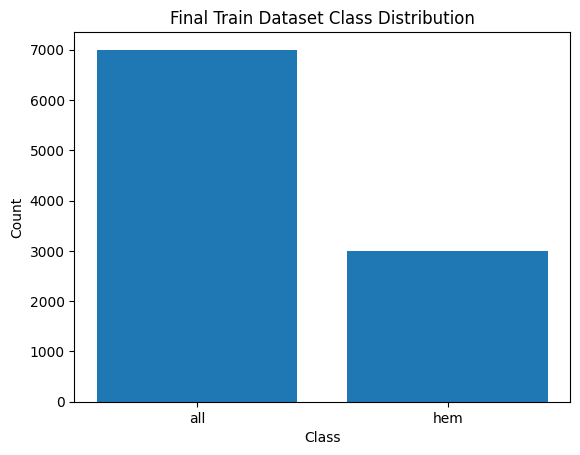

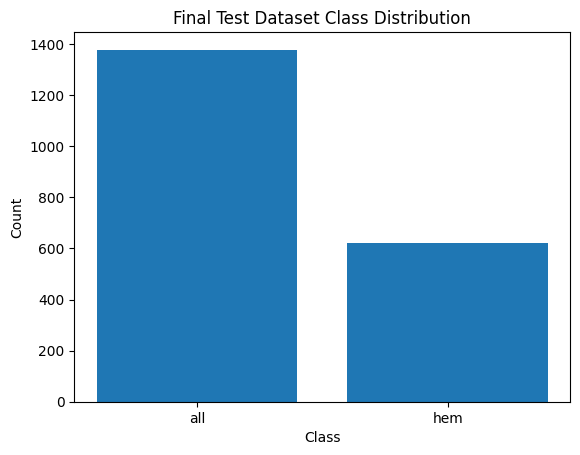

In [5]:
# Data loaders for train and test datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Print the number of data points in train and test loaders
print(f"Number of data points in train loader: {len(train_dataset)}")
print(f"Number of data points in test loader: {len(test_dataset)}")

# Function to get class distribution for a dataset
def get_class_distribution(dataset):
    class_counts = Counter()
    for _, label in dataset:
        class_counts[label] += 1
    return class_counts

# Get class distribution for train and test datasets
train_class_distribution = get_class_distribution(train_dataset)
test_class_distribution = get_class_distribution(test_dataset)

# Plotting function
def plot_class_distribution(class_distribution, title):
    classes = list(class_distribution.keys())
    counts = list(class_distribution.values())

    plt.bar(classes, counts)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(classes, [class_names[i] for i in classes])
    plt.show()

# Plot class distributions
plot_class_distribution(train_class_distribution, "Final Train Dataset Class Distribution")
plot_class_distribution(test_class_distribution, "Final Test Dataset Class Distribution")

In [6]:
model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    torch.nn.Linear(num_ftrs, 4),
    torch.nn.Linear(4, 2),
)  # Assuming binary classification

model

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
Freeze = False
if Freeze:
    # Freeze the base model
    for param in model.parameters():
        param.requires_grad = False

    # Only train the last fully connected layer
    for param in model.fc.parameters():
        param.requires_grad = True

In [8]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Determine the device (CPU or GPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

train_losses = []
val_losses = []
train_accs = []
val_accs = []

In [9]:
num_epochs = 64
best_loss = 1000

for epoch in range(num_epochs):
    model.to(device)  # Move the model to the device
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Training)", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)  # Move the data to the device
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_acc = 100 * correct / total
    train_accs.append(train_acc)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}, Training Accuracy: {train_acc}%')

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm.tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)  # Move the data to the device
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(test_loader)
    val_losses.append(val_loss)
    val_acc = 100 * correct / total
    val_accs.append(val_acc)
    
    if val_loss < best_loss:
        print("Saving model...")
        torch.save(model.state_dict(), 'model.pth')
        best_loss = val_loss

    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}%')
torch.save(model.state_dict(), 'model_last.pth')

Epoch 1/64 (Training): 100%|███████████████| 313/313 [04:21<00:00,  1.20batch/s]


Epoch 1/64, Training Loss: 0.30221993211930553, Training Accuracy: 87.67%


Epoch 1/64 (Validation): 100%|███████████████| 63/63 [00:39<00:00,  1.58batch/s]


Saving model...
Epoch 1/64, Validation Loss: 0.36850682444988736, Validation Accuracy: 83.55%


Epoch 2/64 (Training): 100%|███████████████| 313/313 [04:10<00:00,  1.25batch/s]


Epoch 2/64, Training Loss: 0.1892475856426425, Training Accuracy: 92.8%


Epoch 2/64 (Validation): 100%|███████████████| 63/63 [00:39<00:00,  1.58batch/s]


Epoch 2/64, Validation Loss: 0.37966264760683455, Validation Accuracy: 86.2%


Epoch 3/64 (Training): 100%|███████████████| 313/313 [04:18<00:00,  1.21batch/s]


Epoch 3/64, Training Loss: 0.1259437465903382, Training Accuracy: 95.24%


Epoch 3/64 (Validation): 100%|███████████████| 63/63 [00:39<00:00,  1.58batch/s]


Saving model...
Epoch 3/64, Validation Loss: 0.24722793166126525, Validation Accuracy: 88.8%


Epoch 4/64 (Training): 100%|███████████████| 313/313 [04:11<00:00,  1.24batch/s]


Epoch 4/64, Training Loss: 0.08910397736998364, Training Accuracy: 96.87%


Epoch 4/64 (Validation): 100%|███████████████| 63/63 [00:40<00:00,  1.57batch/s]


Saving model...
Epoch 4/64, Validation Loss: 0.058932179015957646, Validation Accuracy: 97.9%


Epoch 5/64 (Training): 100%|███████████████| 313/313 [04:11<00:00,  1.24batch/s]


Epoch 5/64, Training Loss: 0.05544749388550096, Training Accuracy: 97.92%


Epoch 5/64 (Validation): 100%|███████████████| 63/63 [00:40<00:00,  1.55batch/s]


Epoch 5/64, Validation Loss: 0.11410756793523592, Validation Accuracy: 95.4%


Epoch 6/64 (Training): 100%|███████████████| 313/313 [04:15<00:00,  1.22batch/s]


Epoch 6/64, Training Loss: 0.05323778714437168, Training Accuracy: 98.17%


Epoch 6/64 (Validation): 100%|███████████████| 63/63 [00:43<00:00,  1.45batch/s]


Epoch 6/64, Validation Loss: 0.081866737436651, Validation Accuracy: 97.5%


Epoch 7/64 (Training): 100%|███████████████| 313/313 [04:21<00:00,  1.20batch/s]


Epoch 7/64, Training Loss: 0.03501593917827702, Training Accuracy: 98.88%


Epoch 7/64 (Validation): 100%|███████████████| 63/63 [00:44<00:00,  1.41batch/s]


Saving model...
Epoch 7/64, Validation Loss: 0.051726565951304065, Validation Accuracy: 98.25%


Epoch 8/64 (Training): 100%|███████████████| 313/313 [04:33<00:00,  1.15batch/s]


Epoch 8/64, Training Loss: 0.022980989755437033, Training Accuracy: 99.23%


Epoch 8/64 (Validation): 100%|███████████████| 63/63 [00:40<00:00,  1.56batch/s]


Saving model...
Epoch 8/64, Validation Loss: 0.030746179905864188, Validation Accuracy: 99.2%


Epoch 9/64 (Training): 100%|███████████████| 313/313 [04:58<00:00,  1.05batch/s]


Epoch 9/64, Training Loss: 0.037264889212713516, Training Accuracy: 98.55%


Epoch 9/64 (Validation): 100%|███████████████| 63/63 [00:43<00:00,  1.45batch/s]


Epoch 9/64, Validation Loss: 0.061605586495716125, Validation Accuracy: 98.05%


Epoch 10/64 (Training): 100%|██████████████| 313/313 [04:58<00:00,  1.05batch/s]


Epoch 10/64, Training Loss: 0.01879185668439024, Training Accuracy: 99.48%


Epoch 10/64 (Validation): 100%|██████████████| 63/63 [00:40<00:00,  1.57batch/s]


Epoch 10/64, Validation Loss: 0.06293392594208912, Validation Accuracy: 98.15%


Epoch 11/64 (Training): 100%|██████████████| 313/313 [04:23<00:00,  1.19batch/s]


Epoch 11/64, Training Loss: 0.020131335188630976, Training Accuracy: 99.22%


Epoch 11/64 (Validation): 100%|██████████████| 63/63 [00:42<00:00,  1.49batch/s]


Epoch 11/64, Validation Loss: 0.030753342020842764, Validation Accuracy: 99.45%


Epoch 12/64 (Training): 100%|██████████████| 313/313 [04:57<00:00,  1.05batch/s]


Epoch 12/64, Training Loss: 0.013184862432159154, Training Accuracy: 99.53%


Epoch 12/64 (Validation): 100%|██████████████| 63/63 [00:43<00:00,  1.45batch/s]


Epoch 12/64, Validation Loss: 0.056487435518878526, Validation Accuracy: 98.55%


Epoch 13/64 (Training): 100%|██████████████| 313/313 [05:00<00:00,  1.04batch/s]


Epoch 13/64, Training Loss: 0.026294574988442444, Training Accuracy: 99.11%


Epoch 13/64 (Validation): 100%|██████████████| 63/63 [00:40<00:00,  1.55batch/s]


Epoch 13/64, Validation Loss: 0.4570032401779105, Validation Accuracy: 89.9%


Epoch 14/64 (Training): 100%|██████████████| 313/313 [04:10<00:00,  1.25batch/s]


Epoch 14/64, Training Loss: 0.022026728806695855, Training Accuracy: 99.32%


Epoch 14/64 (Validation): 100%|██████████████| 63/63 [00:39<00:00,  1.58batch/s]


Epoch 14/64, Validation Loss: 0.03191820692379787, Validation Accuracy: 99.35%


Epoch 15/64 (Training): 100%|██████████████| 313/313 [04:16<00:00,  1.22batch/s]


Epoch 15/64, Training Loss: 0.006139351210726898, Training Accuracy: 99.86%


Epoch 15/64 (Validation): 100%|██████████████| 63/63 [00:40<00:00,  1.57batch/s]


Epoch 15/64, Validation Loss: 0.03217737736607281, Validation Accuracy: 99.25%


Epoch 16/64 (Training): 100%|██████████████| 313/313 [04:15<00:00,  1.22batch/s]


Epoch 16/64, Training Loss: 0.01950730172167893, Training Accuracy: 99.31%


Epoch 16/64 (Validation): 100%|██████████████| 63/63 [00:39<00:00,  1.60batch/s]


Epoch 16/64, Validation Loss: 0.0379936753184117, Validation Accuracy: 99.05%


Epoch 17/64 (Training): 100%|██████████████| 313/313 [04:12<00:00,  1.24batch/s]


Epoch 17/64, Training Loss: 0.016748076959036774, Training Accuracy: 99.46%


Epoch 17/64 (Validation): 100%|██████████████| 63/63 [00:39<00:00,  1.58batch/s]


Saving model...
Epoch 17/64, Validation Loss: 0.025731611766657028, Validation Accuracy: 99.4%


Epoch 18/64 (Training): 100%|██████████████| 313/313 [04:09<00:00,  1.26batch/s]


Epoch 18/64, Training Loss: 0.014247690347654574, Training Accuracy: 99.55%


Epoch 18/64 (Validation): 100%|██████████████| 63/63 [00:39<00:00,  1.58batch/s]


Epoch 18/64, Validation Loss: 0.053401892374423034, Validation Accuracy: 99.1%


Epoch 19/64 (Training): 100%|██████████████| 313/313 [04:48<00:00,  1.09batch/s]


Epoch 19/64, Training Loss: 0.016055948282511102, Training Accuracy: 99.44%


Epoch 19/64 (Validation): 100%|██████████████| 63/63 [00:44<00:00,  1.43batch/s]


Epoch 19/64, Validation Loss: 0.22168584335004055, Validation Accuracy: 93.55%


Epoch 20/64 (Training): 100%|██████████████| 313/313 [04:29<00:00,  1.16batch/s]


Epoch 20/64, Training Loss: 0.017743523834590665, Training Accuracy: 99.4%


Epoch 20/64 (Validation): 100%|██████████████| 63/63 [00:41<00:00,  1.51batch/s]


Epoch 20/64, Validation Loss: 0.05322475385499217, Validation Accuracy: 99.2%


Epoch 21/64 (Training): 100%|██████████████| 313/313 [03:33<00:00,  1.47batch/s]


Epoch 21/64, Training Loss: 0.0111974351596098, Training Accuracy: 99.67%


Epoch 21/64 (Validation): 100%|██████████████| 63/63 [00:32<00:00,  1.95batch/s]


Epoch 21/64, Validation Loss: 0.048147855436019155, Validation Accuracy: 98.8%


Epoch 22/64 (Training): 100%|██████████████| 313/313 [02:30<00:00,  2.08batch/s]


Epoch 22/64, Training Loss: 0.015547211681795845, Training Accuracy: 99.4%


Epoch 22/64 (Validation): 100%|██████████████| 63/63 [00:32<00:00,  1.96batch/s]


Epoch 22/64, Validation Loss: 0.02651778546761119, Validation Accuracy: 99.4%


Epoch 23/64 (Training): 100%|██████████████| 313/313 [02:34<00:00,  2.03batch/s]


Epoch 23/64, Training Loss: 0.010336844167839376, Training Accuracy: 99.65%


Epoch 23/64 (Validation): 100%|██████████████| 63/63 [00:33<00:00,  1.91batch/s]


Epoch 23/64, Validation Loss: 0.03835616437315785, Validation Accuracy: 99.4%


Epoch 24/64 (Training): 100%|██████████████| 313/313 [02:33<00:00,  2.04batch/s]


Epoch 24/64, Training Loss: 0.013983403843440828, Training Accuracy: 99.44%


Epoch 24/64 (Validation): 100%|██████████████| 63/63 [00:32<00:00,  1.92batch/s]


Epoch 24/64, Validation Loss: 0.06522123932391258, Validation Accuracy: 98.1%


Epoch 25/64 (Training): 100%|██████████████| 313/313 [02:29<00:00,  2.09batch/s]


Epoch 25/64, Training Loss: 0.011365290523245697, Training Accuracy: 99.61%


Epoch 25/64 (Validation): 100%|██████████████| 63/63 [00:41<00:00,  1.53batch/s]


Epoch 25/64, Validation Loss: 0.04377588757687056, Validation Accuracy: 99.3%


Epoch 26/64 (Training): 100%|██████████████| 313/313 [03:37<00:00,  1.44batch/s]


Epoch 26/64, Training Loss: 0.0038714967904466997, Training Accuracy: 99.85%


Epoch 26/64 (Validation): 100%|██████████████| 63/63 [00:31<00:00,  1.98batch/s]


Epoch 26/64, Validation Loss: 0.04227937747066515, Validation Accuracy: 99.35%


Epoch 27/64 (Training): 100%|██████████████| 313/313 [02:30<00:00,  2.08batch/s]


Epoch 27/64, Training Loss: 0.0016644922081160386, Training Accuracy: 99.96%


Epoch 27/64 (Validation): 100%|██████████████| 63/63 [00:32<00:00,  1.96batch/s]


Epoch 27/64, Validation Loss: 0.058355862451597726, Validation Accuracy: 99.35%


Epoch 28/64 (Training): 100%|██████████████| 313/313 [02:29<00:00,  2.09batch/s]


Epoch 28/64, Training Loss: 0.011105328917200329, Training Accuracy: 99.61%


Epoch 28/64 (Validation): 100%|██████████████| 63/63 [00:32<00:00,  1.92batch/s]


Epoch 28/64, Validation Loss: 0.06728521600275093, Validation Accuracy: 98.0%


Epoch 29/64 (Training): 100%|██████████████| 313/313 [02:28<00:00,  2.10batch/s]


Epoch 29/64, Training Loss: 0.020221715224204545, Training Accuracy: 99.26%


Epoch 29/64 (Validation): 100%|██████████████| 63/63 [00:32<00:00,  1.95batch/s]


Epoch 29/64, Validation Loss: 0.05616721573529676, Validation Accuracy: 98.5%


Epoch 30/64 (Training): 100%|██████████████| 313/313 [02:30<00:00,  2.08batch/s]


Epoch 30/64, Training Loss: 0.011075324673392185, Training Accuracy: 99.6%


Epoch 30/64 (Validation): 100%|██████████████| 63/63 [00:32<00:00,  1.94batch/s]


Epoch 30/64, Validation Loss: 0.06021659258274465, Validation Accuracy: 99.4%


Epoch 31/64 (Training): 100%|██████████████| 313/313 [03:13<00:00,  1.62batch/s]


Epoch 31/64, Training Loss: 0.009730773423509668, Training Accuracy: 99.68%


Epoch 31/64 (Validation): 100%|██████████████| 63/63 [00:43<00:00,  1.45batch/s]


Epoch 31/64, Validation Loss: 0.06169270278446169, Validation Accuracy: 99.15%


Epoch 32/64 (Training): 100%|██████████████| 313/313 [05:02<00:00,  1.04batch/s]


Epoch 32/64, Training Loss: 0.005460861183798614, Training Accuracy: 99.79%


Epoch 32/64 (Validation): 100%|██████████████| 63/63 [00:43<00:00,  1.43batch/s]


Epoch 32/64, Validation Loss: 0.05888048589592169, Validation Accuracy: 99.15%


Epoch 33/64 (Training): 100%|██████████████| 313/313 [05:07<00:00,  1.02batch/s]


Epoch 33/64, Training Loss: 0.010983463456191623, Training Accuracy: 99.58%


Epoch 33/64 (Validation): 100%|██████████████| 63/63 [00:45<00:00,  1.38batch/s]


Epoch 33/64, Validation Loss: 0.037688036825668875, Validation Accuracy: 99.45%


Epoch 34/64 (Training): 100%|██████████████| 313/313 [04:48<00:00,  1.09batch/s]


Epoch 34/64, Training Loss: 0.007778834780753842, Training Accuracy: 99.73%


Epoch 34/64 (Validation): 100%|██████████████| 63/63 [00:42<00:00,  1.49batch/s]


Epoch 34/64, Validation Loss: 0.057662855273458755, Validation Accuracy: 99.4%


Epoch 35/64 (Training): 100%|██████████████| 313/313 [04:58<00:00,  1.05batch/s]


Epoch 35/64, Training Loss: 0.010839883760366119, Training Accuracy: 99.63%


Epoch 35/64 (Validation): 100%|██████████████| 63/63 [00:43<00:00,  1.44batch/s]


Epoch 35/64, Validation Loss: 0.05200677158957241, Validation Accuracy: 99.45%


Epoch 36/64 (Training): 100%|██████████████| 313/313 [04:36<00:00,  1.13batch/s]


Epoch 36/64, Training Loss: 0.006957212651128319, Training Accuracy: 99.73%


Epoch 36/64 (Validation): 100%|██████████████| 63/63 [00:32<00:00,  1.92batch/s]


Epoch 36/64, Validation Loss: 0.09818831330377568, Validation Accuracy: 98.85%


Epoch 37/64 (Training): 100%|██████████████| 313/313 [02:32<00:00,  2.06batch/s]


Epoch 37/64, Training Loss: 0.011537604736078354, Training Accuracy: 99.71%


Epoch 37/64 (Validation): 100%|██████████████| 63/63 [00:32<00:00,  1.94batch/s]


Epoch 37/64, Validation Loss: 0.04770056635723969, Validation Accuracy: 99.3%


Epoch 38/64 (Training): 100%|██████████████| 313/313 [02:34<00:00,  2.02batch/s]


Epoch 38/64, Training Loss: 0.008071739462580465, Training Accuracy: 99.67%


Epoch 38/64 (Validation): 100%|██████████████| 63/63 [00:32<00:00,  1.93batch/s]


Epoch 38/64, Validation Loss: 0.1799860356478882, Validation Accuracy: 95.3%


Epoch 39/64 (Training): 100%|██████████████| 313/313 [02:35<00:00,  2.01batch/s]


Epoch 39/64, Training Loss: 0.005718015790680278, Training Accuracy: 99.82%


Epoch 39/64 (Validation): 100%|██████████████| 63/63 [00:33<00:00,  1.88batch/s]


Epoch 39/64, Validation Loss: 0.030989332794224392, Validation Accuracy: 99.5%


Epoch 40/64 (Training): 100%|██████████████| 313/313 [02:40<00:00,  1.95batch/s]


Epoch 40/64, Training Loss: 0.003972742907534123, Training Accuracy: 99.89%


Epoch 40/64 (Validation): 100%|██████████████| 63/63 [00:33<00:00,  1.89batch/s]


Epoch 40/64, Validation Loss: 0.04689852198409051, Validation Accuracy: 99.5%


Epoch 41/64 (Training): 100%|██████████████| 313/313 [02:39<00:00,  1.96batch/s]


Epoch 41/64, Training Loss: 0.006889167981621729, Training Accuracy: 99.77%


Epoch 41/64 (Validation): 100%|██████████████| 63/63 [00:32<00:00,  1.92batch/s]


Epoch 41/64, Validation Loss: 0.05654927745538208, Validation Accuracy: 99.4%


Epoch 42/64 (Training): 100%|██████████████| 313/313 [02:51<00:00,  1.83batch/s]


Epoch 42/64, Training Loss: 0.010369160567328721, Training Accuracy: 99.6%


Epoch 42/64 (Validation): 100%|██████████████| 63/63 [00:34<00:00,  1.85batch/s]


Epoch 42/64, Validation Loss: 0.19241844871569247, Validation Accuracy: 93.6%


Epoch 43/64 (Training): 100%|██████████████| 313/313 [05:51<00:00,  1.12s/batch]


Epoch 43/64, Training Loss: 0.009281329829115803, Training Accuracy: 99.65%


Epoch 43/64 (Validation): 100%|██████████████| 63/63 [00:32<00:00,  1.96batch/s]


Epoch 43/64, Validation Loss: 0.13860274618676316, Validation Accuracy: 95.1%


Epoch 44/64 (Training): 100%|██████████████| 313/313 [14:57<00:00,  2.87s/batch]


Epoch 44/64, Training Loss: 0.00300341346862439, Training Accuracy: 99.91%


Epoch 44/64 (Validation): 100%|██████████████| 63/63 [00:47<00:00,  1.34batch/s]


Epoch 44/64, Validation Loss: 0.06041857701623644, Validation Accuracy: 99.45%


Epoch 45/64 (Training): 100%|██████████████| 313/313 [05:18<00:00,  1.02s/batch]


Epoch 45/64, Training Loss: 0.00040145489411645593, Training Accuracy: 99.99%


Epoch 45/64 (Validation): 100%|██████████████| 63/63 [00:48<00:00,  1.30batch/s]


Epoch 45/64, Validation Loss: 0.047400688808900825, Validation Accuracy: 99.5%


Epoch 46/64 (Training): 100%|██████████████| 313/313 [04:35<00:00,  1.13batch/s]


Epoch 46/64, Training Loss: 0.0002534851732941123, Training Accuracy: 99.99%


Epoch 46/64 (Validation): 100%|██████████████| 63/63 [00:41<00:00,  1.53batch/s]


Epoch 46/64, Validation Loss: 0.04595043528222299, Validation Accuracy: 99.55%


Epoch 47/64 (Training): 100%|██████████████| 313/313 [04:50<00:00,  1.08batch/s]


Epoch 47/64, Training Loss: 0.028858238887944487, Training Accuracy: 99.0%


Epoch 47/64 (Validation): 100%|██████████████| 63/63 [00:41<00:00,  1.53batch/s]


Epoch 47/64, Validation Loss: 0.04945357212688707, Validation Accuracy: 99.55%


Epoch 48/64 (Training): 100%|██████████████| 313/313 [04:42<00:00,  1.11batch/s]


Epoch 48/64, Training Loss: 0.006946808763018816, Training Accuracy: 99.8%


Epoch 48/64 (Validation): 100%|██████████████| 63/63 [00:40<00:00,  1.55batch/s]


Epoch 48/64, Validation Loss: 0.052394535416083056, Validation Accuracy: 99.1%


Epoch 49/64 (Training): 100%|██████████████| 313/313 [17:23<00:00,  3.33s/batch]


Epoch 49/64, Training Loss: 0.0025095542070642093, Training Accuracy: 99.95%


Epoch 49/64 (Validation): 100%|██████████████| 63/63 [00:32<00:00,  1.96batch/s]


Epoch 49/64, Validation Loss: 0.05445606225019594, Validation Accuracy: 99.55%


Epoch 50/64 (Training): 100%|██████████████| 313/313 [02:28<00:00,  2.11batch/s]


Epoch 50/64, Training Loss: 0.000520074293893132, Training Accuracy: 99.99%


Epoch 50/64 (Validation): 100%|██████████████| 63/63 [00:32<00:00,  1.96batch/s]


Epoch 50/64, Validation Loss: 0.05063027307537884, Validation Accuracy: 99.5%


Epoch 51/64 (Training): 100%|██████████████| 313/313 [02:28<00:00,  2.10batch/s]


Epoch 51/64, Training Loss: 0.0002781579355785263, Training Accuracy: 99.99%


Epoch 51/64 (Validation): 100%|██████████████| 63/63 [00:32<00:00,  1.96batch/s]


Epoch 51/64, Validation Loss: 0.04835033617695848, Validation Accuracy: 99.5%


Epoch 52/64 (Training): 100%|██████████████| 313/313 [02:29<00:00,  2.09batch/s]


Epoch 52/64, Training Loss: 0.012850137129401203, Training Accuracy: 99.57%


Epoch 52/64 (Validation): 100%|██████████████| 63/63 [00:32<00:00,  1.96batch/s]


Epoch 52/64, Validation Loss: 0.050477098786532656, Validation Accuracy: 98.9%


Epoch 53/64 (Training): 100%|██████████████| 313/313 [02:32<00:00,  2.05batch/s]


Epoch 53/64, Training Loss: 0.016593058308553562, Training Accuracy: 99.48%


Epoch 53/64 (Validation): 100%|██████████████| 63/63 [00:32<00:00,  1.96batch/s]


Epoch 53/64, Validation Loss: 0.03573665986599706, Validation Accuracy: 99.45%


Epoch 54/64 (Training): 100%|██████████████| 313/313 [02:31<00:00,  2.06batch/s]


Epoch 54/64, Training Loss: 0.0010845559012662629, Training Accuracy: 99.98%


Epoch 54/64 (Validation): 100%|██████████████| 63/63 [00:32<00:00,  1.95batch/s]


Epoch 54/64, Validation Loss: 0.04178676115999758, Validation Accuracy: 99.5%


Epoch 55/64 (Training): 100%|██████████████| 313/313 [02:33<00:00,  2.04batch/s]


Epoch 55/64, Training Loss: 0.0005050228361278787, Training Accuracy: 100.0%


Epoch 55/64 (Validation): 100%|██████████████| 63/63 [00:32<00:00,  1.94batch/s]


Epoch 55/64, Validation Loss: 0.045544108837277004, Validation Accuracy: 99.5%


Epoch 56/64 (Training): 100%|██████████████| 313/313 [02:32<00:00,  2.05batch/s]


Epoch 56/64, Training Loss: 9.55840830478462e-05, Training Accuracy: 100.0%


Epoch 56/64 (Validation): 100%|██████████████| 63/63 [00:32<00:00,  1.94batch/s]


Epoch 56/64, Validation Loss: 0.04642726935497335, Validation Accuracy: 99.45%


Epoch 57/64 (Training): 100%|██████████████| 313/313 [02:32<00:00,  2.06batch/s]


Epoch 57/64, Training Loss: 6.792672857822829e-05, Training Accuracy: 100.0%


Epoch 57/64 (Validation): 100%|██████████████| 63/63 [00:32<00:00,  1.95batch/s]


Epoch 57/64, Validation Loss: 0.04879250848733593, Validation Accuracy: 99.45%


Epoch 58/64 (Training): 100%|██████████████| 313/313 [02:30<00:00,  2.08batch/s]


Epoch 58/64, Training Loss: 4.6483913246637955e-05, Training Accuracy: 100.0%


Epoch 58/64 (Validation): 100%|██████████████| 63/63 [00:32<00:00,  1.94batch/s]


Epoch 58/64, Validation Loss: 0.0502608529866411, Validation Accuracy: 99.5%


Epoch 59/64 (Training): 100%|██████████████| 313/313 [02:35<00:00,  2.01batch/s]


Epoch 59/64, Training Loss: 0.017178480067924898, Training Accuracy: 99.45%


Epoch 59/64 (Validation): 100%|██████████████| 63/63 [00:33<00:00,  1.87batch/s]


Epoch 59/64, Validation Loss: 0.34675420572360355, Validation Accuracy: 88.05%


Epoch 60/64 (Training): 100%|██████████████| 313/313 [02:40<00:00,  1.95batch/s]


Epoch 60/64, Training Loss: 0.013255287333925425, Training Accuracy: 99.57%


Epoch 60/64 (Validation): 100%|██████████████| 63/63 [00:33<00:00,  1.88batch/s]


Epoch 60/64, Validation Loss: 0.05740713120719322, Validation Accuracy: 99.3%


Epoch 61/64 (Training): 100%|██████████████| 313/313 [02:36<00:00,  2.00batch/s]


Epoch 61/64, Training Loss: 0.004286884569333901, Training Accuracy: 99.88%


Epoch 61/64 (Validation): 100%|██████████████| 63/63 [00:33<00:00,  1.89batch/s]


Epoch 61/64, Validation Loss: 0.034919380426106816, Validation Accuracy: 99.6%


Epoch 62/64 (Training): 100%|██████████████| 313/313 [02:36<00:00,  2.00batch/s]


Epoch 62/64, Training Loss: 0.010889642187829538, Training Accuracy: 99.63%


Epoch 62/64 (Validation): 100%|██████████████| 63/63 [00:33<00:00,  1.89batch/s]


Epoch 62/64, Validation Loss: 0.16765007389975445, Validation Accuracy: 94.65%


Epoch 63/64 (Training): 100%|██████████████| 313/313 [02:34<00:00,  2.02batch/s]


Epoch 63/64, Training Loss: 0.0026154732731695006, Training Accuracy: 99.95%


Epoch 63/64 (Validation): 100%|██████████████| 63/63 [00:33<00:00,  1.87batch/s]


Epoch 63/64, Validation Loss: 0.03727995721120741, Validation Accuracy: 99.6%


Epoch 64/64 (Training): 100%|██████████████| 313/313 [02:54<00:00,  1.79batch/s]


Epoch 64/64, Training Loss: 0.0002126977295951054, Training Accuracy: 100.0%


Epoch 64/64 (Validation): 100%|██████████████| 63/63 [00:33<00:00,  1.88batch/s]


Epoch 64/64, Validation Loss: 0.04818841901264716, Validation Accuracy: 99.6%


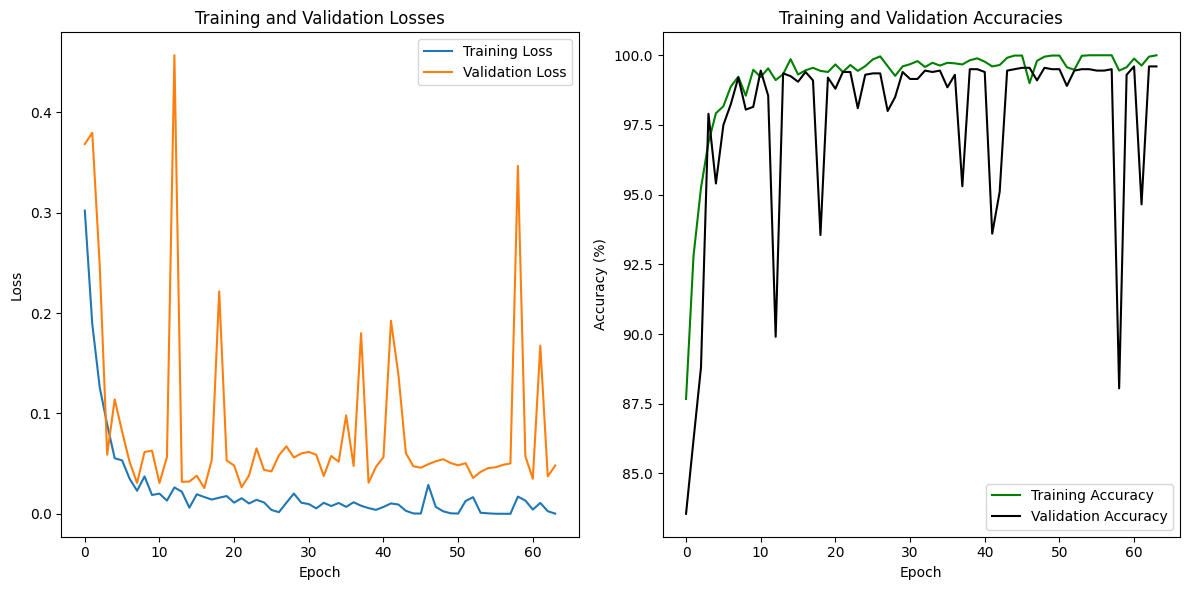

In [10]:
## Plotting the Losses and Accuracies
plt.figure(figsize=(12, 6))

# Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# Accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy', color='green')
plt.plot(val_accs, label='Validation Accuracy', color='black')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracies')
plt.legend()


plt.tight_layout()
plt.show()


In [12]:
# Load the saved model weights
model_path = 'model.pth'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [13]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import time

# Set the model to evaluation mode
model.eval()

# Initialize variables for metrics
correct = 0
total = 0
all_labels = []
all_predictions = []

# Start time
start_time = time.time()

# No gradient calculation needed for evaluation
with torch.no_grad():
    for inputs, labels in test_loader:  # Use test_loader for evaluation
        outputs = model(inputs.to(device))
        _, predicted = torch.max(outputs.data.to('cpu'), 1)
        
        # Update correct and total counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Collect all labels and predictions for further metrics
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# End time
end_time = time.time()
computational_time = end_time - start_time

# Accuracy
accuracy = 100 * correct / total

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Precision, Recall, F1 Score
precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# For multi-class classification, handle the confusion matrix appropriately
# Print the confusion matrix
print('Confusion Matrix:')
print(conf_matrix)

# For binary classification, get true positives, false positives, etc.
if conf_matrix.shape == (2, 2):
    tn, fp, fn, tp = conf_matrix.ravel()  # Confusion matrix for binary classification
    sensitivity = tp / (tp + fn)  # True Positive Rate (Recall)
    specificity = tn / (tn + fp)  # True Negative Rate
else:
    # For multi-class classification, you might need to calculate metrics differently
    sensitivity = None
    specificity = None

# Error Rate
error_rate = 1 - accuracy / 100

# Print Metrics
print(f'Accuracy: {accuracy}%')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
if sensitivity is not None and specificity is not None:
    print(f'Sensitivity: {sensitivity}')
    print(f'Specificity: {specificity}')
print(f'Error Rate: {error_rate}')
print(f'Computational Time: {computational_time:.2f} seconds')

Confusion Matrix:
[[1376    2]
 [  10  612]]
Accuracy: 99.4%
Precision: 0.994015830712899
Recall: 0.994
F1 Score: 0.9939892655922893
Sensitivity: 0.9839228295819936
Specificity: 0.9985486211901307
Error Rate: 0.005999999999999894
Computational Time: 34.00 seconds
